In [106]:
import os
from tqdm import tqdm
import torch
from matplotlib import pyplot as plt

import models
from lib.config import Config
from lib.metrics import MetricTracker, SegmentationARI
import lib.setup_model as setup_model
import lib.visualizations as visualizations
import data
from CONFIG import CONFIG

In [107]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
DATA_PATH = "/home/user/villar/datasets"
EXP_PATH = "/home/user/villar/ObjectCentricVideoPred/experiments"
CONFIG["paths"]["data_path"] = DATA_PATH

# EXP_NAME = "exps_angel/test_sprites"
# MODEL = "checkpoint_epoch_final_300.pth"
EXP_NAME = "exps_ismail/SA4I-VMDS-batch-size-64"
MODEL = "checkpoint_epoch_final.pth"
EXP_NAME = "exps_angel/test_spmot"
# MODEL = "checkpoint_epoch_final.pth"

In [109]:
exp_path = os.path.join(EXP_PATH, EXP_NAME)
checkpoint_path = os.path.join(exp_path, "models", MODEL)

cfg = Config(exp_path)
exp_params = cfg.load_exp_config_file()

## Loading Data

In [110]:
# dataset = data.MultiDSpvisualizationses(path=DATA_PATH, mode="test")
dataset = data.load_data(dataset_name=exp_params["dataset"]["dataset_name"], split="test")

self.num_samples 1000
imgs.shape (1000, 10, 3, 64, 64)


In [115]:
imgs, masks = dataset[3]
if imgs.ndim == 4:
    img = imgs[0]
    masks = masks[0:1]
else:
    img = imgs

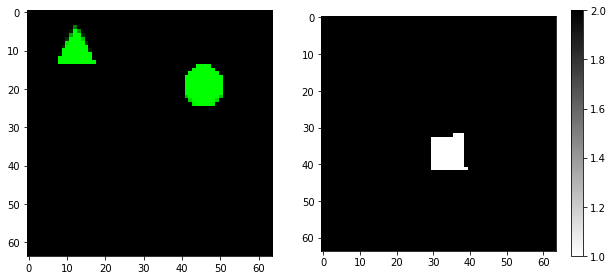

In [116]:
plt.figure(figsize=(9, 4))
plt.subplot(1,2,1)
plt.imshow(img.permute(1, 2, 0))
plt.subplot(1,2,2)
plt.imshow(masks.permute(1, 2, 0), cmap="gray_r")
plt.colorbar()
plt.tight_layout()
plt.show()

## Setting Up Pretrained Model

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
model = setup_model.setup_model(model_params=exp_params["model"])
model = setup_model.load_checkpoint(
                checkpoint_path=checkpoint_path,
                model=model,
                only_model=True
            )
model = model.eval().to(device)

False
resolution=[64, 64], downsample_encoder=False, upsample = 4, decoder_resolution=[64, 64] 
resolution: [64, 64] , hidden_size: 32
hidden_size=32,resolution=[64, 64]
resolution: [64, 64] , hidden_size: 64
hidden_size=64,resolution=[64, 64]


## Processing One Image

In [76]:
imgs, masks = dataset[4]
# imgs, masks = imgs.unsqueeze(0).to(device), masks.unsqueeze(0).to(device)
imgs, masks = imgs.to(device), masks.to(device)

In [77]:
with torch.no_grad():
    reconstructions, (recons, pred_masks, slot_embs) = model(imgs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


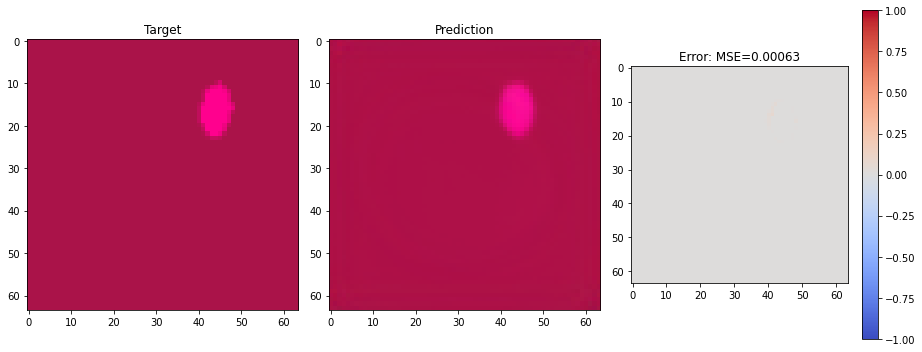

In [78]:
plt.figure(figsize=(13, 5))
plt.subplot(1, 3, 1)
plt.title("Target")
plt.imshow(imgs[0].cpu().permute(1, 2, 0))
plt.subplot(1, 3, 2)
plt.title("Prediction")
plt.imshow(reconstructions[0].cpu().permute(1, 2, 0))
plt.subplot(1, 3, 3)
err = (reconstructions[0] - imgs[0]).pow(2).sum(dim=0).cpu()
plt.imshow(err, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()
plt.title(f"Error: MSE={round(err.mean().item(), 5)}")

plt.tight_layout()
plt.show()

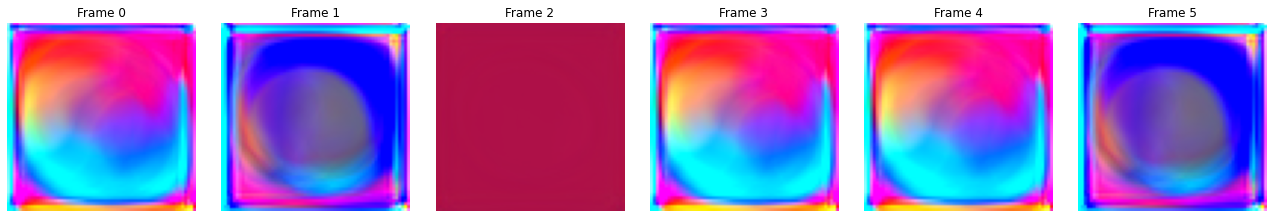

In [79]:
_ = visualizations.visualize_sequence(recons[0], n_cols=6)

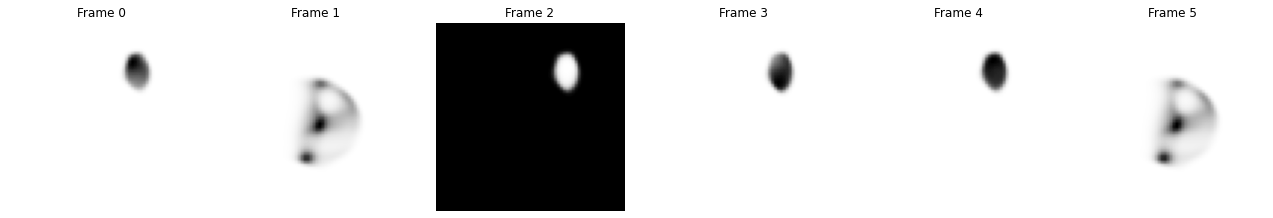

In [80]:
_ = visualizations.visualize_sequence(pred_masks[0], n_cols=6, cmap="gray_r")

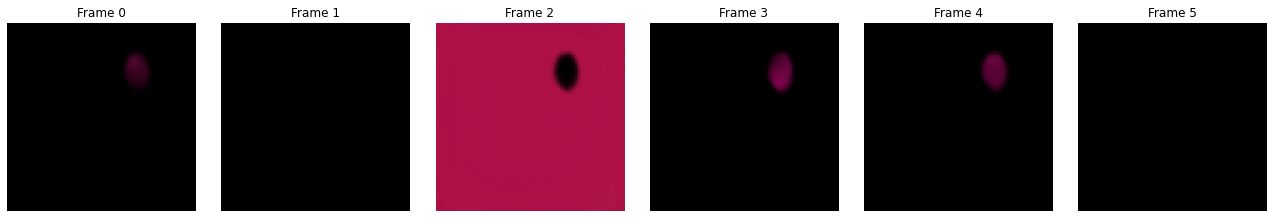

In [81]:
_ = visualizations.visualize_sequence(pred_masks[0] * recons[0], n_cols=6)

## Processing Metrics

In [52]:
metric_tracker = MetricTracker(
                exp_path,
                metrics=["segmentation_ari"],
                num_slots=exp_params["model"]["SlotAttention"]["num_slots"],
                use_tboard=False
            )

In [53]:
metric_tracker.reset_results()
N_TRIALS = 10

for i in tqdm(range(len(dataset))):
    img, masks = dataset[i]
    img, masks = img.unsqueeze(0).to(device), masks.unsqueeze(0).to(device)
    n_targets = len(masks.unique())
    
    for _ in range(N_TRIALS):
        with torch.no_grad():
            reconstructions, (recons, pred_masks, slot_embs) = model(img, n_targets)
        combined_masks = torch.argmax(pred_masks, dim=1)
        metric_tracker.accumulate(preds=combined_masks, targets=masks)
    metric_tracker.get_best_trial(num_trials=N_TRIALS)
    
    cur_score = metric_tracker.metric_computers["segmentation_ari"].ari_scores[-1]
    if cur_score < 0.01:
        print(f"Breaking at id {i} with score {cur_score}")
        # break

  0%|                                                                                                                                          | 0/1000 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 4)

In [50]:
ari_scores = metric_tracker.metric_computers["segmentation_ari"].ari_scores
sorted_scores, sorted_locs = torch.sort(torch.tensor(ari_scores), descending=True)
print(f"Best 5 scores: {sorted_scores[:5]} at IDs {sorted_locs[:5]}")
print(f"Worst 5 scores: {sorted_scores[-5:]} at IDs {sorted_locs[-5:]}")

Best 5 scores: tensor([]) at IDs tensor([], dtype=torch.int64)
Worst 5 scores: tensor([]) at IDs tensor([], dtype=torch.int64)


In [51]:
metric_tracker.aggregate()
_ = metric_tracker.summary()

ZeroDivisionError: division by zero

  Trial 1: ARI: 0.03910823505272537
  Trial 2: ARI: 0.01558426861847231
  Trial 3: ARI: 0.03910823505272537
  Trial 4: ARI: 0.03910823505272537
  Trial 5: ARI: 0.03910823505272537
  Trial 6: ARI: 0.03910823505272537
  Trial 7: ARI: 0.03910823505272537
  Trial 8: ARI: 0.02711314796414052
  Trial 9: ARI: 0.03910823505272537
  Trial 10: ARI: 0.02711314796414052
ARI: [0.03910823505272537]


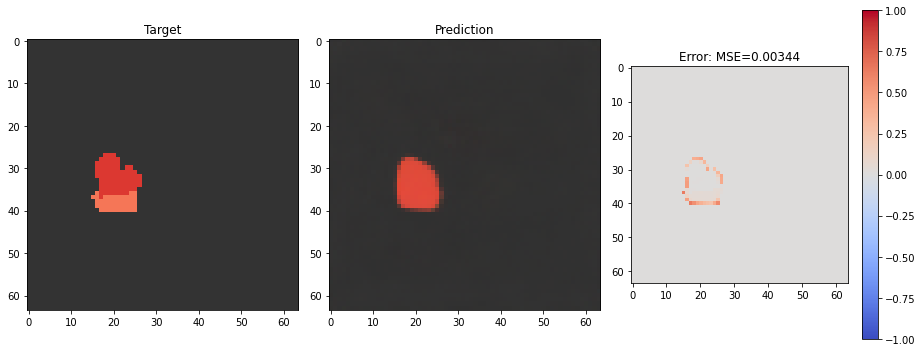

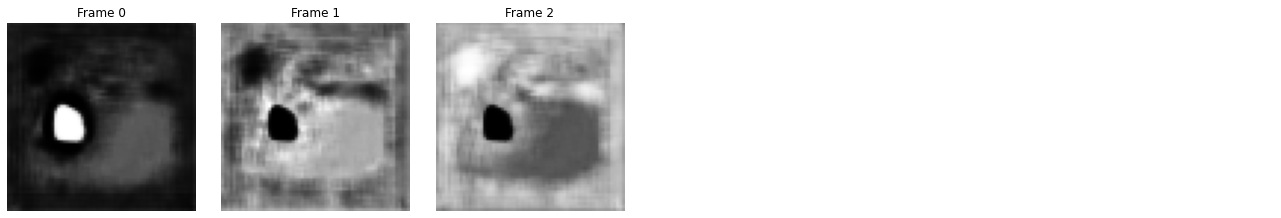

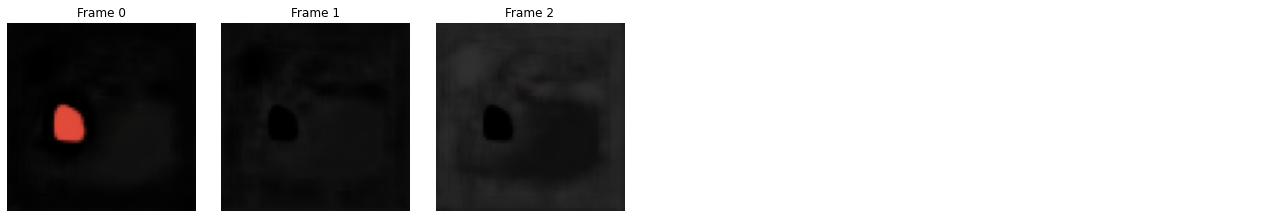

In [374]:
img, masks = dataset[230]
img, masks = img.unsqueeze(0).to(device), masks.unsqueeze(0).to(device)
num_targets = len(masks.unique())

ari = SegmentationARI(n_instances=6)

for i in range(N_TRIALS):
    with torch.no_grad():
        reconstructions, (recons, pred_masks, slot_embs) = model(img, num_slots=num_targets)
    combined_masks = torch.argmax(pred_masks, dim=1)    
    ari.accumulate(combined_masks, masks)
    print(f"  Trial {i+1}: ARI: {ari.ari_scores[-1]}")

ari.get_best_trial(N_TRIALS)
print(f"ARI: {ari.ari_scores}")

visualizations.visualize_img_err(img=img, reconstructions=reconstructions)
_ = visualizations.visualize_sequence(pred_masks[0], n_cols=6, cmap="gray")
_ = visualizations.visualize_sequence(pred_masks[0] * recons[0], n_cols=6)